In [2]:
import pandas as pd
import numpy as np
import scipy


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

## Jeux de données
Jeux de données de protéomique quantitative au format TSV, `TCL_wt1.tsv`

## Objectifs
##### 1 Lire et traiter des données d'entrée avec [PANDAS](https://pandas.pydata.org/)
    * Specification du type des colonnes
    * Nettoyage des valeurs incorrectes

##### 2 Représenter la distribution empirique des "fold-change" (**FC**)
    * Representation d'une grille d'histogrammes
    * Explorer l'effet du paramètre: nombre de catégories (*bins*)
    * Se familliariser avec les objets Axes et Figure
    
##### 3 Evaluer un seuil de **FDR** 5%, avec une approximation par noyau Gaussien de la distribution.
    * Génération d'un jeu de données unimodal (génération par une loi normale)
    * A partir de cet echantillon, estimation par noyau gaussien d'une densité de probabilité
    * Determiner le seuil alpha des 5% de valeurs extrêmes de la densité de probabilité

##### 4 Evaluer un seuil de **FDR** 5% sur les données d'abondance experimentales.
    * Choisir un histogramme avec un nombre de catégores pertinent
    * Y Superposer la courbe de la densité de probabilité obtenue en suivant la méthode[3]
    * Annoter et légender la figure


## Ressources
https://www.bioconductor.org/help/course-materials/2015/SeattleApr2015/E_GeneSetEnrichment.html

https://matplotlib.org/gallery.html#




## Format des données expérimentales

Le terme *RA*, désigne le **R**atio d'**A**bondance pour une protéines entre deux expériences.

Les valeurs de **RA** sont stockées dans la colonne `Log2 Corrected Abundance Ratio`.

Un "ratio" négatif indique qu'une protéine est moins présente dans l'experience considérée par rapport à une experience de référence.

* La condition experimentale de référence est un milieu de croissance bactérienne
* La condition experimentale testée est un milieu riche en Tétracycline 



# Première exploration des données

### Lecture des valeurs experimentales
Charger ```TCL_wt1.tsv``` dans une [dataframe pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).
##### [Comment filtrer des lignes Pandas](https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/)
###### pandas.[read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) a de nombreuses options bien utiles notamment 
* dtype
* na_values

<span style="color:firebrick;font-weight:bold"> $\rhd$ 
Retirer les lignes présentant des aberrations numériques
</span>

Utile pour la suite: si nécessaire, une colonne pandas peut être [convertie](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.to_list.html?highlight=to_list#pandas.Series.to_list) en liste python.

In [4]:
data = pd.read_csv("../TCL_wt1.tsv", sep="\t",  dtype={'Corrected Abundance ratio (1.53)':np.float64, 'Log2 Corrected Abundance Ratio':np.float64, 'Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT)':np.float64, 'LOG10 Adj.P-val':np.float64}, na_values='#VALEUR!').dropna()
data

,Accession,Description,Gene Symbol,Corrected Abundance ratio (1.53),Log2 Corrected Abundance Ratio,Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT),LOG10 Adj.P-val
0,P75936,Basal-body rod modification protein FlgD OS=Es...,flgD,0.075817,-3.721335,0.000055,4.260067
1,P76231,Uncharacterized protein YeaC OS=Escherichia co...,yeaC,0.092810,-3.429569,0.000351,3.454627
2,P0A8S9,Flagellar transcriptional regulator FlhD OS=Es...,flhD,0.102614,-3.284695,0.000027,4.571899
4,P05706,PTS system glucitol/sorbitol-specific EIIA com...,srlB,0.108497,-3.204277,0.019963,1.699768
5,P29744,Flagellar hook-associated protein 3 OS=Escheri...,flgL,0.124183,-3.009460,0.036746,1.434787
...,...,...,...,...,...,...,...
2011,P77330,Prophage lipoprotein Bor homolog OS=Escherichi...,borD,1.535948,0.619129,0.310725,0.507623
2016,P02930,Outer membrane protein TolC OS=Escherichia col...,tolC,1.552288,0.634396,0.013373,1.873757
2020,P0A917,Outer membrane protein X OS=Escherichia coli (...,ompX,1.579739,0.659686,0.002226,2.652391
2021,P02931,Outer membrane protein F OS=Escherichia coli (...,ompF,1.754902,0.811390,0.000068,4.164956


###### Représenter la distribution des **RA** des protéines de l'experience [**Log2 Corrected Abundance Ratio**]
La méthode [Axes.hist()](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.hist.html#matplotlib.axes.Axes.hist) permet de dessiner des histogrammes.

Rappel: La taile de la grille est donnée par les paramètres *ncols, nrows*, comme dans lci dessous
  
`fig1, ( (ax1, ax2), (ax3, ax4) ) = plt.subplots(figsize=(10,6), ncols=2, nrows=2)`

Les valeurs du paramètre *bin* peuvent fortement influencer la forme de l'histogramme.


<span style="color:firebrick;font-weight:bold"> $\rhd$Réaliser une grille 2x2 avec 4 histogrammes, chacun étant paramétré avec une valeur différente de l'option *bins*. Choisissez, quatre valeurs illustrant l'effet du paramètre bin. Vous ajouterez un titre à chaque histogramme indiquant son nombre de bins/catégorie</span>

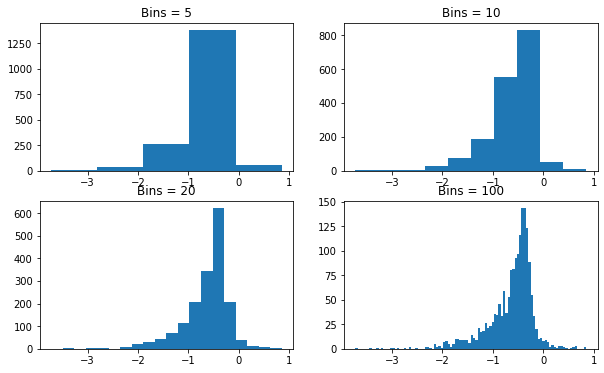

In [5]:
fig1, ((ax1, ax2),(ax3, ax4)) = plt.subplots(figsize=(10,6), ncols=2, nrows=2)
ax1.hist(data["Log2 Corrected Abundance Ratio"], bins=5)
ax1.set_title("Bins = 5")
ax2.hist(data["Log2 Corrected Abundance Ratio"], bins=10)
ax2.set_title("Bins = 10")
ax3.hist(data["Log2 Corrected Abundance Ratio"], bins=20)
ax3.set_title("Bins = 20")
ax4.hist(data["Log2 Corrected Abundance Ratio"], bins=100)
ax4.set_title("Bins = 100")
plt.show()
# bins = parametre de largeur de bande

### Représenter et utiliser la densité de probabilité estimée à partir d'un échantillon
 A.Démonstration sur un jeu de données aléatoire simple
   1. Génération de l'échantillon à partir d'une loi normale
   2. Histogramme des valeurs de l'échantillon
   3. Estimation de la densité de probabilité à partir de l'échantillon
   4. Comparaison et superposition de l'histogramme et de la courbe de densité
   5. Determiner et représenter un seuil de valeurs remarquables parmi l'échantillon
   
B. Application de cette technique au jeu de données expérimentales

###### 1/ Générer 1000 valeurs normalement distribuées.
```python
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
print(f"s est un tableau de {len(s)} valeurs normalement distribuées autour de {mu}")
print(f"Les 10 premières valeurs de s sont \n{s[:10]}")
```
<span style="color:green;font-weight:bold">$\uparrow$ Reproduire cet exemple dans la cellule ci-dessous.$\downarrow$ </span>

In [6]:
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
print(f"s est un tableau de {len(s)} valeurs normalement distribuées autour de {mu}")
print(f"Les 10 premières valeurs de s sont \n{s[:10]}")

s est un tableau de 1000 valeurs normalement distribuées autour de 0
Les 10 premières valeurs de s sont 
[ 0.10367986 -0.05783723  0.18245317 -0.08650653  0.058094   -0.13051673
 -0.01244461  0.03901019  0.0570923  -0.03859959]


###### 2/ Créer une figure dotée d'un seul "axe"
Dessinons-y l'histogramme des valeurs précedemment générées
```python
fig2, f2_ax = plt.subplots(figsize=(5,3), ncols=1, nrows=1)
count, bins, barObj = f2_ax.hist(s, 50, density=True) 
```

<span style="color:green;font-weight:bold">$\uparrow$ Reproduire cet exemple dans la cellule ci-dessous $\downarrow$ </span>

<span style="color:firebrick;font-weight:bold"> $\rhd$ Inspecter les contenus des variables *count* et *bin* retournées par la méthode Axes.hist()</span>


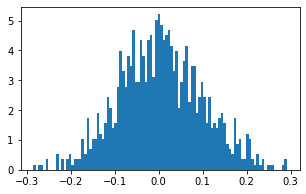

In [7]:
fig2, f2_ax = plt.subplots(figsize=(5,3), ncols=1, nrows=1)
count, bins, barObj = f2_ax.hist(s, 100, density=True) 

###### 3/ Estimer la densité de probabilité à partir de l'échantillon de 1000 valeurs par une technique de noyau gaussien
Oui c'est bête :D, nous savons que la densité sous-jacente est celle d'une loi normale, mais l'exemple est ainsi assez simple.
```python
from scipy.stats.kde import gaussian_kde
pdf_by_gaussian = gaussian_kde(s)
```

<span style="color:green;font-weight:bold">$\uparrow$ Reproduire cet exemple dans la cellule ci-dessous $\downarrow$ </span>
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ Expliquer les valeurs retournés par <br/><i>pdf_by_gaussian(-1)</i><br/><i>pdf_by_gaussian(0)</i><br/><i>pdf_by_gaussian(-1)</i></span>


In [8]:
from scipy.stats.kde import gaussian_kde
pdf_by_gaussian = gaussian_kde(s) #Representation of a kernel-density estimate using Gaussian kernels on a normal density
print(pdf_by_gaussian(-1)) 
print(pdf_by_gaussian(0))
print(pdf_by_gaussian(1))
#retourne un effectif theorique attendu sous la loi normal

[9.68071438e-198]
[4.2404128]
[6.00405676e-194]


###### 3(suite)/ Générer la courbe cette densité
* Prenons 1000 points points également répartis entre le minimum et le maximum du jeu de données
* Générons les valeurs correspondantes dans la densité
```$python
x_kde = np.linspace(min(s),max(s), 1000)
y_kde = pdf_by_gaussian(x_kde)
```

<span style="color:green;font-weight:bold">$\uparrow$ Reproduire cet exemple dans la cellule ci-dessous $\downarrow$ </span>

<span style="color:firebrick;font-weight:bold">$\rhd$ Dessiner ces deux listes de valeurs dans un graphique [simple](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html) </span>

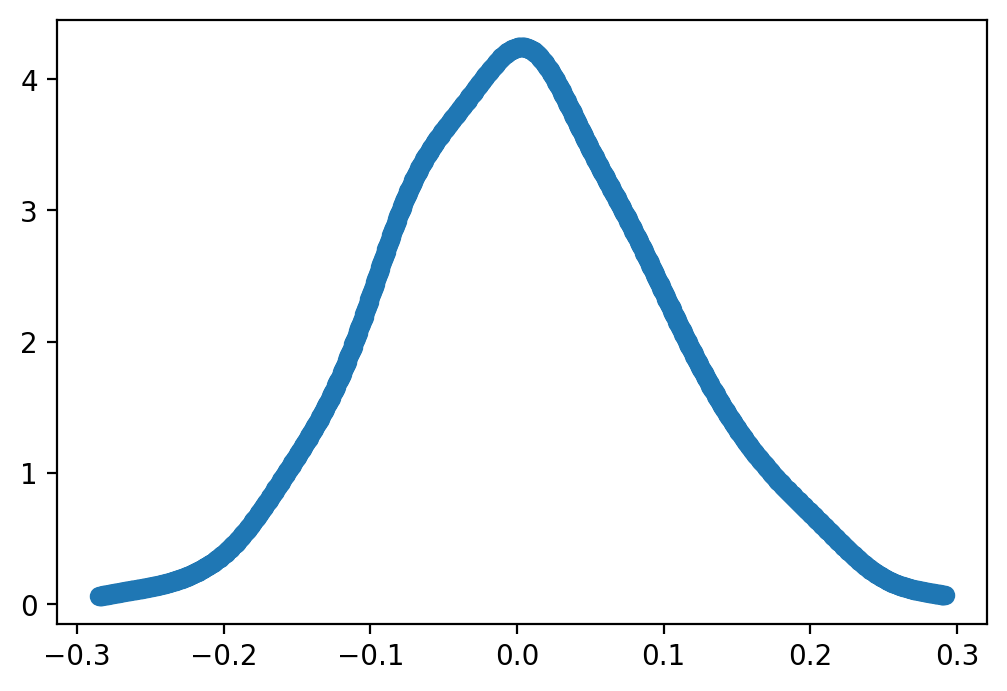

In [9]:
x_kde = np.linspace(min(s),max(s), 1000)
y_kde = pdf_by_gaussian(x_kde)

fig3, ax3 = plt.subplots(dpi=200)
ax3.scatter(x_kde, y_kde)
plt.show()

#### 4/ Représentation graphique de la courbe de densité et de l'histogramme d'échantillon
<span style="color:firebrick;font-weight:bold">$\rhd$Combiner en une figure l'histogramme obtenu en <span style="font-weight:bold">[2]</span> et la courbe de la densité de probabilité obtenue en <span style="font-weight:bold">[3]</span></span>

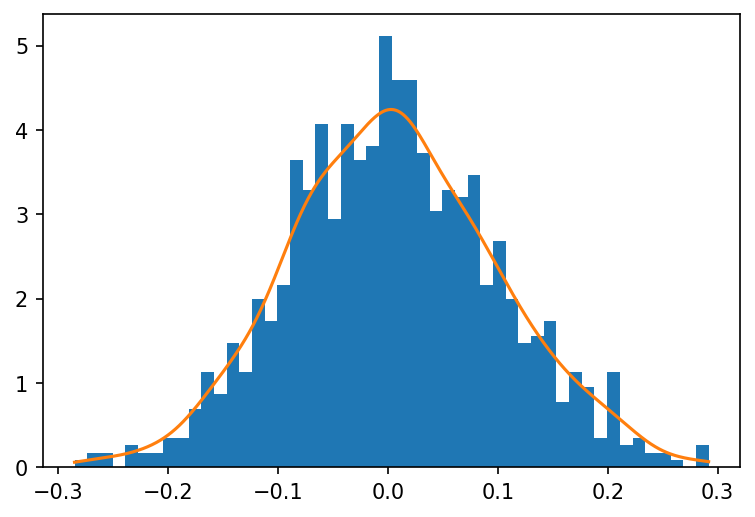

In [10]:
fig4,ax3  = plt.subplots(dpi=150)
ax3.hist(s, 50, density=True)
ax3.plot(x_kde, y_kde)
plt.show()

<span style="color:green;font-weight:bold">$\uparrow$ En se basant sur la figure précédente$\downarrow$ </span>

Mettez le paramètre `density` à False sur `count, bins, barObj = f2_ax.hist(s, 50, density=True)`
<br/><span style="color:firebrick;font-weight:bold">$\rhd$ Qu'observez-vous en ordonnées? Les unités ont-elles changées ? Pourquoi ?</span>
<br/><span style="color:firebrick;font-weight:bold">$\rhd$  Pouvez-vous expliquer le changement de "forme" de la courbe de densité?</span>
<br/><span style="color:firebrick;font-weight:bold">$\rhd$  L'aire sous la courbe et/ou sous l'histogramme change-t-elle avec la valeur du paramètre <span style="font-weight:normal">`density`?</span></span>

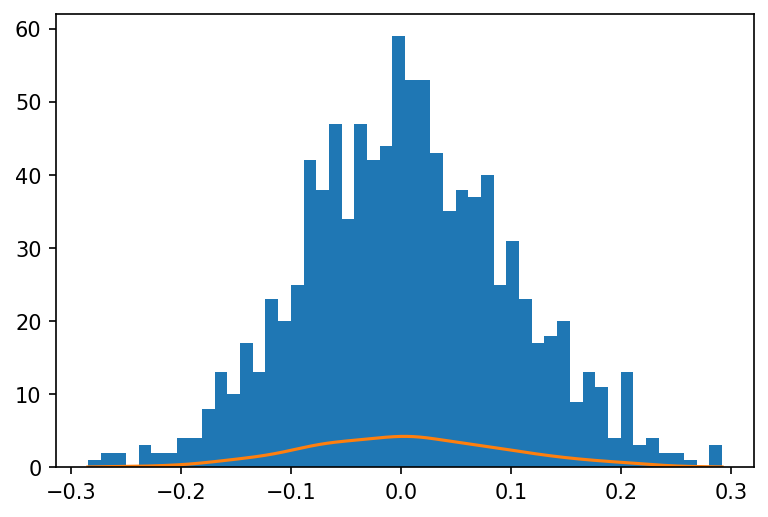

In [11]:
fig4,ax3  = plt.subplots(dpi=150)
ax3.hist(s, 50, density=False)
ax3.plot(x_kde, y_kde)
plt.show()
# density = True <-> les valeurs sont normalisées, la somme de tous les rectangles font 1, donc les comptages sont réduits.
# largeur d'une catégorie dans mon plot = dx
# facteur d'échelle (scale) = dx*effectif

Peut-on imaginer une technique pour dessiner histogramme et courbe de densité avec les bonnes unités en ordonnée ?
Les variables count et bins peuvent notamment vous aider à calculer l'aire totale sous l'histogramme.
<br/><span style="color:firebrick;font-weight:bold">$\rhd$  Dessiner histogramme et courbe de densité avec les bonnes unités et les légendes et titres correspondants.</span>

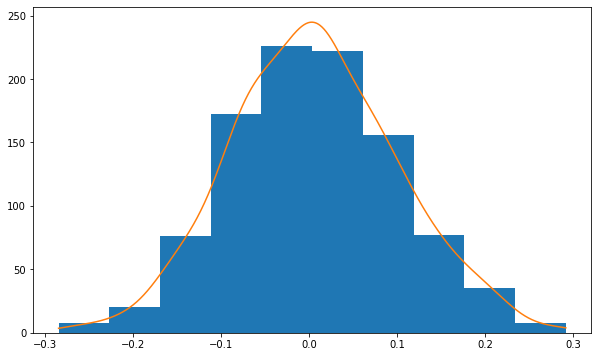

In [12]:
fig4,ax3  = plt.subplots(figsize=(10,6), ncols=1, nrows=1)
hist_res = ax3.hist(s,density=False)
dx = hist_res[1][1] - hist_res[1][0] # - bin width in current plot
scale = dx * len(s)                  # - each observable in sample has

ax3.plot(x_kde, y_kde*scale)         # an height of 1 in current plot
plt.show()
# on veut ploter un histogramme avec les vrais comptages.

#### 4/ Recherche du seuil alpha

Le package scipy.integrate permet de calculer l'intégrale exacte d'une fonction 

`integral_value, residu = scipy.integrate.quad(f, borne_inf, borne_sup)`

A l'aide de l'exemple ci-dessus:
<br/><span style="color:firebrick;font-weight:bold">$\rhd$Calculer la valeur de l'aire sous la courbe de densité estimée entre les valeurs minimale et maximale du jeux de données.</span>
<br/><span style="color:firebrick;font-weight:bold">$\rhd$Chercher la borne d'intégration inférieure **alpha** correspondant "à peu près" à 5% de l'aire totale sous la courbe de la densité de probabilité estimée.</span>


In [13]:
i =1
while (scipy.integrate.quad(pdf_by_gaussian,min(s),x_kde[i])[0] < 0.975):
    i+=1
print("Born sup = ",x_kde[i])
Borne_sup = x_kde[i]
Borne_sup_i = i

Born sup =  0.20636551232327344


In [14]:
i =1
while (scipy.integrate.quad(pdf_by_gaussian,min(s),x_kde[i])[0] < 0.05):
    i+=1
print("Born inf = ",x_kde[i])
Borne_inf = x_kde[i]
Borne_inf_i = i

Born inf =  -0.15032673357204251


In [16]:
def find_alpha(f, integr_ratio, epsilon, dataset):
    intg_tot = scipy.integrate.quad(f, min(dataset), max(dataset))[0]
    dx = 0.001
    x = min(dataset)
    intg_step = scipy.integrate.quad(f,x,max(dataset))[0]
    S = (intg_step/intg_tot)
    a_gauche = True
    
    while abs(S-integr_ratio) > epsilon:
        intg_step = scipy.integrate.quad(f,x,max(dataset))[0]
        S = (intg_step/intg_tot)
        
        if a_gauche:
            if S > integr_ratio:
                x = x + dx
            else:
                x = x - dx
                a_gauche = !a_gauche
                dx = dx/2
        elif a_gauche:
            if S > integr_ratio:
                x = x + dx
                a_gauche = !a_gauche
                dx = dx/2
            else:
                x = x - dx

    return x

In [17]:
f = gaussian_kde(data["Log2 Corrected Abundance Ratio"])
Borne_sup = find_alpha(f, 0.05, 0.001, data["Log2 Corrected Abundance Ratio"])
print(Borne_sup)

-0.0993349420002988


###### 5/ Représentation graphique du seuil alpha
Redessinez le graphique *histogramme et courbe de densité* mais avec:
<br/><span style="color:firebrick;font-weight:bold">$\rhd$une ligne verticale rouge matérialisant le seuil <i>alpha</i></span>
<br/><span style="color:firebrick;font-weight:bold">$\rhd$Un [texte](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html) `alpha(5%) = {valeur de alpha}`</span>
<br/><span style="color:firebrick;font-weight:bold">$\rhd$(Bonus) coloriez en rouge [l'aire sous la courbe](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.fill_between.html) de densité correspondant à l'intégrale calculée.</span>

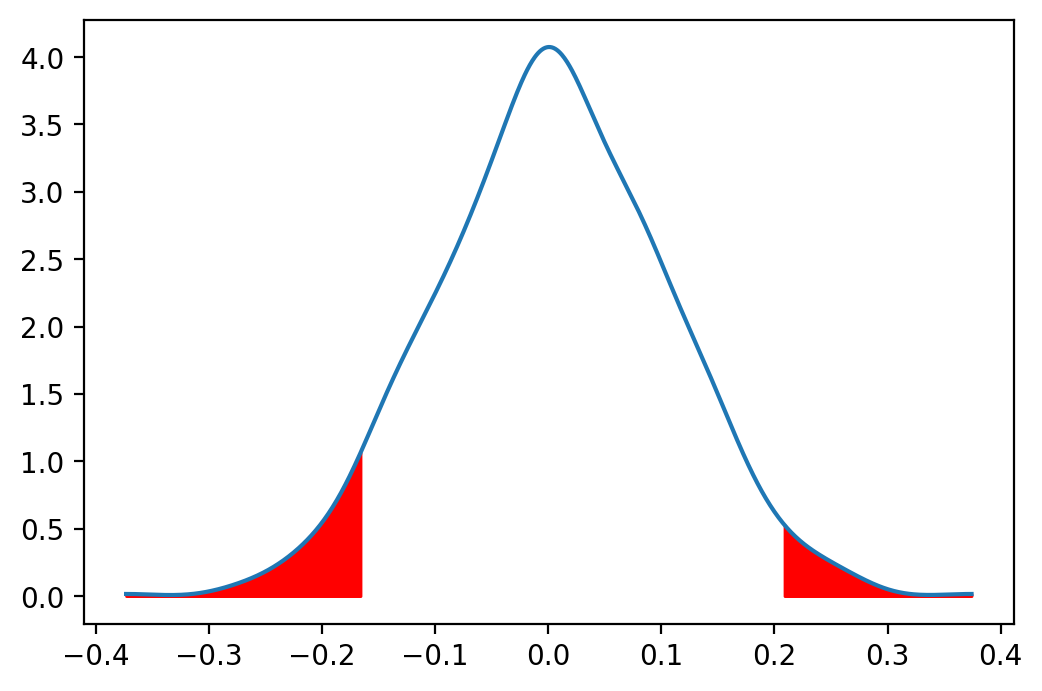

In [213]:
fig4,ax3  = plt.subplots(dpi=200)
# hist_res = ax3.hist(s,density=False)
# dx = hist_res[1][1] - hist_res[1][0]
# scale = dx * len(s)                  

ax3.plot(x_kde, y_kde)
# ax3.axvline(Borne_sup, color="red")
# ax3.axvline(borne_inf, color="red")
ax3.fill_between(x_kde[Borne_sup_i:],y_kde[Borne_sup_i:],color="red")
ax3.fill_between(x_kde[:Borne_inf_i],y_kde[:Borne_inf_i],color="red")
plt.show()

## Appliquez cette méthode pour determiner un seuil alpha pour le Ratio d'Abondance
$\Rightarrow$ Echantillon de valeurs `Log2 Corrected Abundance Ratio`
1. Estimation de la densité à partir de l'échantillon par noyau gaussien 
2. Calcul du seuil alpha
3. Représentation graphique
    * Histogramme
    * Densité 
    * seuil alpha

In [100]:
x

0      -3.721335
1      -3.429569
2      -3.284695
4      -3.204277
5      -3.009460
          ...   
2011    0.619129
2016    0.634396
2020    0.659686
2021    0.811390
2022    0.846424
Name: Log2 Corrected Abundance Ratio, Length: 1746, dtype: float64

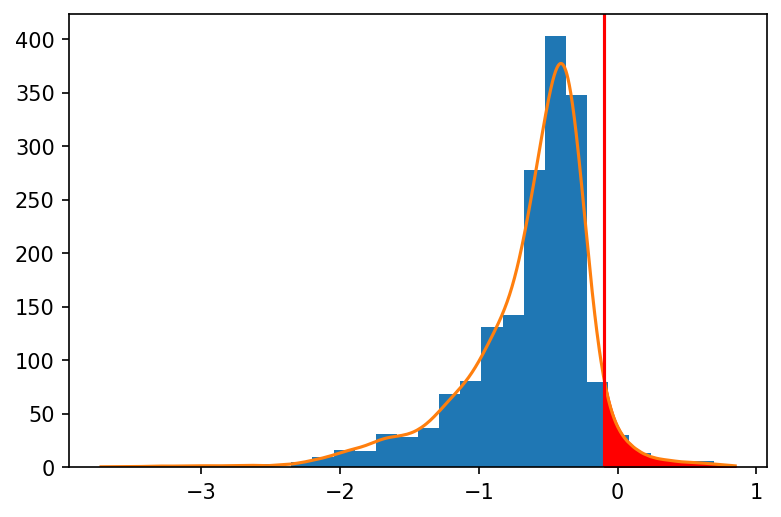

In [112]:
fig5,ax4  = plt.subplots(dpi=150) 
x = data["Log2 Corrected Abundance Ratio"]
y = pdf_by_gaussian(x)
hist_res = ax4.hist(x, bins=30, density=False)
dx = hist_res[1][1] - hist_res[1][0] # - bin width in current plot
scale = dx * len(x)

ax4.plot(x, y*scale)
ax4.axvline(Borne_sup, color="red")
ax4.fill_between(x,y*scale,where=x>Borne_sup,color="red")
plt.show()